In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
#import important libraries
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix 
import pickle
import time
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator

from imblearn import under_sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

In [ ]:
#load the dataset from pickled files
pickle_in = open("/content/drive/MyDrive/Covid/features_set.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/Covid/labels_set.pickle","rb")
y = pickle.load(pickle_in)
y = to_categorical(y)

In [ ]:
#split into train and test datasets
X_train,X_test,y_train,y_test=train_test_split(X,y, train_size=0.75,test_size=0.25,random_state=123)
print(X_train.shape)
print(y_train.shape)

(86802, 80, 80, 1)
(86802, 2)


In [ ]:
IMG_SIZE = 80

In [ ]:
over = RandomOverSampler(sampling_strategy=0.7)
X_both, y_both = over.fit_resample(X_train.reshape(-1, IMG_SIZE * IMG_SIZE * 1), y_train)
X_both = X_both.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_both = to_categorical(y_both)
under = RandomUnderSampler(sampling_strategy=0.7, replacement=False)
X_both, y_both = under.fit_resample(X_both.reshape(-1, IMG_SIZE * IMG_SIZE * 1), y_both)
X_both = X_both.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_both = to_categorical(y_both)
print(X_both.shape, y_both.shape)

(142872, 80, 80, 1) (142872, 2)


In [ ]:
smote = SMOTE(sampling_strategy=0.7)
X_ada, y_ada = smote.fit_resample(X_train.reshape(-1, IMG_SIZE * IMG_SIZE * 1), y_train)
X_ada = X_ada.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_ada = to_categorical(y_ada)
under = RandomUnderSampler(sampling_strategy=0.7)
X_ada, y_ada = under.fit_resample(X_ada.reshape(-1, IMG_SIZE * IMG_SIZE * 1), y_ada)
X_ada = X_ada.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_ada = to_categorical(y_ada)
print(X_ada.shape, y_ada.shape)

(142872, 80, 80, 1) (142872, 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 76, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 64)        0

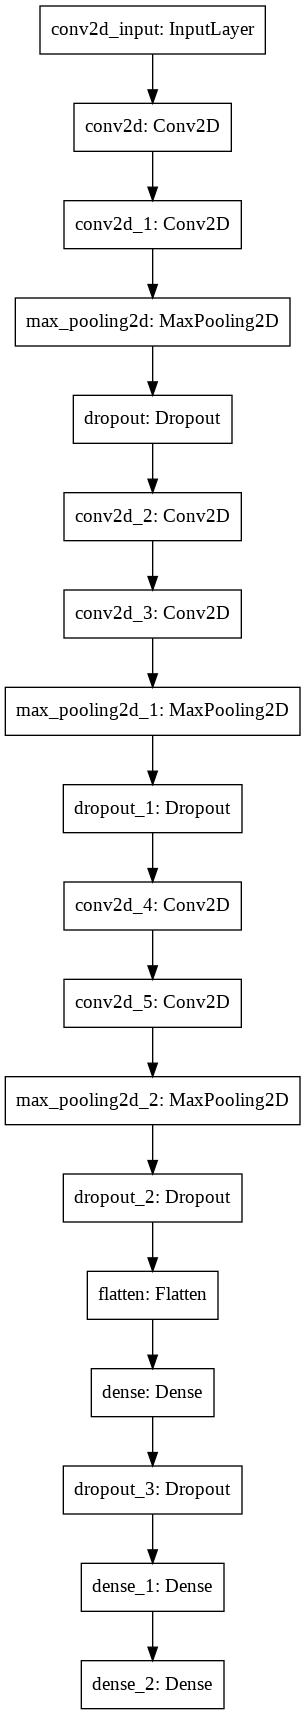

In [ ]:
#Build the model
from tensorflow.keras.utils import plot_model
visible1 = (80,80,1)
model = Sequential()
model.add(Conv2D(128, (3, 3),input_shape=visible1,activation='relu'))
model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))          
model.add(Dense(2,activation='sigmoid'))
model.summary()
plot_model(model, to_file='convolutional_neural_network.png')

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],)

In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

start = time.perf_counter()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc1 = ModelCheckpoint('best_model_mixed.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
mc2 = ModelCheckpoint('best_model_smote_mixed.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

mc3 = ModelCheckpoint('best_model_ros.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

mc4 = ModelCheckpoint('best_model_rus.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

mc5 = ModelCheckpoint('best_model_smote.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

mc6 = ModelCheckpoint('best_model_mixed_20.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
mc7 = ModelCheckpoint('best_model_smote_mixed_20.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history_mixed_only=model.fit(X_both, y_both, batch_size=64, epochs=100, validation_split=0.2,shuffle=1, callbacks=[es, mc1], class_weight=None)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/100
1786/1786 [==============================] - 205s 96ms/step - loss: 0.4490 - accuracy: 0.7650 - precision: 0.7642 - recall: 0.7637 - val_loss: 0.2080 - val_accuracy: 0.8947 - val_precision: 0.8951 - val_recall: 0.8941

Epoch 00001: val_accuracy improved from -inf to 0.89466, saving model to best_model_mixed.h5
Epoch 2/100
1786/1786 [==============================] - 171s 96ms/step - loss: 0.1917 - accuracy: 0.9267 - precision: 0.9264 - recall: 0.9265 - val_loss: 0.1147 - val_accuracy: 0.9478 - val_precision: 0.9483 - val_recall: 0.9474

Epoch 00002: val_accuracy improved from 0.89466 to 0.94775, saving model to best_model_mixed.h5
Epoch 3/100
1786/1786 [==============================] - 171s 96ms/step - loss: 0.1166 - accuracy: 0.9576 - precision: 0.9575 - recall: 0.9575 - val_loss: 0.1117 - val_accuracy: 0.9534 - val_precision: 0.9533 - val_recall: 0.9534

Epoch 00003: val_accuracy improved from 0.94775 to 0.95339, saving model to best_model_mixed.h5
Epoch 4/100
1786/1786 

In [ ]:
history_mixed_only=model.fit(X_train_mixed, y_train_mixed, batch_size=64, epochs=100, validation_split=0.2,shuffle=1, callbacks=[es, mc1], class_weight=None)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/100
237/237 [==============================] - 24s 98ms/step - loss: 0.6980 - accuracy: 0.6601 - precision_1: 0.6578 - recall_1: 0.6573 - val_loss: 0.6414 - val_accuracy: 0.6719 - val_precision_1: 0.6719 - val_recall_1: 0.6719

Epoch 00001: val_accuracy improved from -inf to 0.67187, saving model to best_model_mixed.h5
Epoch 2/100
237/237 [==============================] - 23s 96ms/step - loss: 0.5407 - accuracy: 0.7023 - precision_1: 0.7019 - recall_1: 0.7040 - val_loss: 0.3855 - val_accuracy: 0.8213 - val_precision_1: 0.8232 - val_recall_1: 0.8186

Epoch 00002: val_accuracy improved from 0.67187 to 0.82126, saving model to best_model_mixed.h5
Epoch 3/100
237/237 [==============================] - 22s 95ms/step - loss: 0.3828 - accuracy: 0.8259 - precision_1: 0.8251 - recall_1: 0.8248 - val_loss: 0.3444 - val_accuracy: 0.8369 - val_precision_1: 0.8387 - val_recall_1: 0.8361

Epoch 00003: val_accuracy improved from 0.82126 to 0.83686, saving model to best_model_mixed.h5
Epoch 4

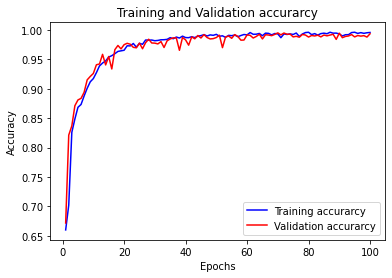

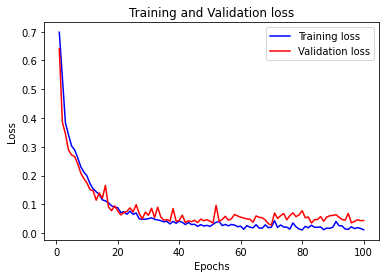

In [ ]:
acc = history_mixed_only.history['accuracy']
val_acc = history_mixed_only.history['val_accuracy']
loss = history_mixed_only.history['loss']
val_loss = history_mixed_only.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Results on test dataset
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_mixed.h5')
y_pred = saved_model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

453/453 [==============================] - 13s 27ms/step
[1 1 1 ... 1 0 1]
[1 1 1 ... 1 0 1]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       858
           1       1.00      1.00      1.00     28076

    accuracy                           1.00     28934
   macro avg       0.98      0.96      0.97     28934
weighted avg       1.00      1.00      1.00     28934



In [ ]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_mixed.h5')

score,accuracy,precision,recall = saved_model.evaluate(X_both,y_both,verbose=1)
f1 = (2*(precision*recall))/(precision+recall)
print("Train loss is {}".format(score))
print("Train accuracy is {}".format(accuracy))
print("Train Precision is {}".format(precision))
print("Train Recall is {}".format(recall))
print("Train f1_score is {}".format(f1))

4465/4465 [==============================] - 69s 15ms/step - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977
Train loss is 0.013836083933711052
Train accuracy is 0.9977182149887085
Train Precision is 0.9977182149887085
Train Recall is 0.9977182149887085
Train f1_score is 0.9977182149887085


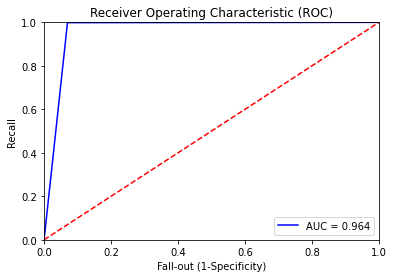

In [ ]:
#Print Area Under Curve
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
false_positive_rate, recall, thresholds = roc_curve(rounded_labels,y_pred_bool)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

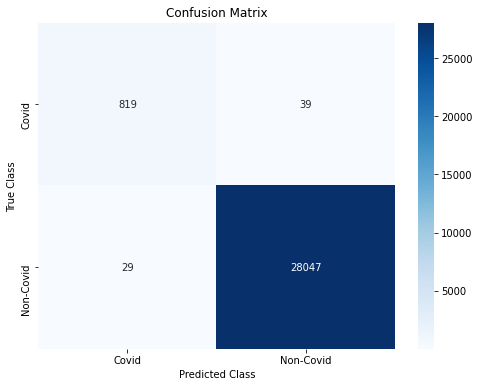

In [ ]:
#Print Confusion Matrix
import seaborn as sns
cm = confusion_matrix(rounded_labels,y_pred_bool)
labels = ['Covid', 'Non-Covid']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

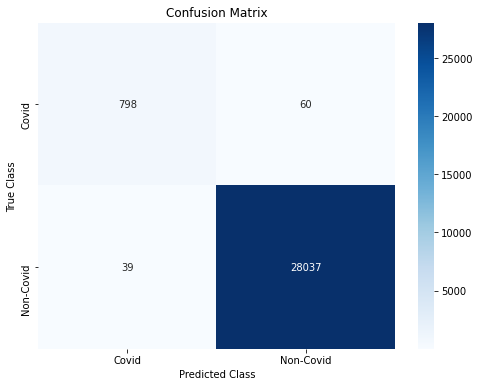

In [ ]:
#Print Confusion Matrix
import seaborn as sns
cm = confusion_matrix(rounded_labels,y_pred_bool)
labels = ['Covid', 'Non-Covid']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

#SMOTE MIXED SAMPLING

In [ ]:
history_mixed_only=model.fit(X_train_mixed_smote, y_train_mixed_smote, batch_size=64, epochs=100, validation_split=0.2,shuffle=1, callbacks=[es, mc2], class_weight=None)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/100
237/237 [==============================] - 80s 199ms/step - loss: 0.5956 - accuracy: 0.7285 - precision: 0.7248 - recall: 0.7259 - val_loss: 0.5256 - val_accuracy: 0.7726 - val_precision: 0.7739 - val_recall: 0.7665

Epoch 00001: val_accuracy improved from -inf to 0.77261, saving model to best_model_smote_mixed.h5
Epoch 2/100
237/237 [==============================] - 45s 191ms/step - loss: 0.4731 - accuracy: 0.7817 - precision: 0.7805 - recall: 0.7818 - val_loss: 0.4510 - val_accuracy: 0.7856 - val_precision: 0.7848 - val_recall: 0.7848

Epoch 00002: val_accuracy improved from 0.77261 to 0.78556, saving model to best_model_smote_mixed.h5
Epoch 3/100
237/237 [==============================] - 45s 191ms/step - loss: 0.3820 - accuracy: 0.8023 - precision: 0.8024 - recall: 0.7997 - val_loss: 0.3127 - val_accuracy: 0.8369 - val_precision: 0.8394 - val_recall: 0.8332

Epoch 00003: val_accuracy improved from 0.78556 to 0.83686, saving model to best_model_smote_mixed.h5
Epoch 4/10

In [ ]:
history_mixed_only=model.fit(X_ada, y_ada, batch_size=64, epochs=100, validation_split=0.2,shuffle=1, callbacks=[es, mc2], class_weight=None)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/100
1786/1786 [==============================] - 381s 195ms/step - loss: 0.2442 - accuracy: 0.8891 - precision: 0.8880 - recall: 0.8893 - val_loss: 0.0419 - val_accuracy: 0.9891 - val_precision: 0.9896 - val_recall: 0.9886

Epoch 00001: val_accuracy improved from -inf to 0.98912, saving model to best_model_smote_mixed.h5
Epoch 2/100
1786/1786 [==============================] - 359s 201ms/step - loss: 0.1208 - accuracy: 0.9524 - precision: 0.9523 - recall: 0.9524 - val_loss: 0.0752 - val_accuracy: 0.9866 - val_precision: 0.9867 - val_recall: 0.9866

Epoch 00002: val_accuracy did not improve from 0.98912
Epoch 3/100
1786/1786 [==============================] - 344s 192ms/step - loss: 0.0837 - accuracy: 0.9689 - precision: 0.9687 - recall: 0.9689 - val_loss: 0.0592 - val_accuracy: 0.9832 - val_precision: 0.9834 - val_recall: 0.9830

Epoch 00003: val_accuracy did not improve from 0.98912
Epoch 4/100
1786/1786 [==============================] - 344s 192ms/step - loss: 0.0626 - accur

In [ ]:
acc = history_mixed_only.history['accuracy']
val_acc = history_mixed_only.history['val_accuracy']
loss = history_mixed_only.history['loss']
val_loss = history_mixed_only.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history_mixed_only.history['accuracy']
val_acc = history_mixed_only.history['val_accuracy']
loss = history_mixed_only.history['loss']
val_loss = history_mixed_only.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Results on test dataset
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_smote_mixed.h5')
y_pred = saved_model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

99/99 [==============================] - 7s 65ms/step
[1 1 0 ... 1 1 0]
[1 1 0 ... 1 1 0]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2093
           1       0.99      0.99      0.99      4210

    accuracy                           0.98      6303
   macro avg       0.98      0.98      0.98      6303
weighted avg       0.98      0.98      0.98      6303



In [ ]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_smote_mixed.h5')

score,accuracy,precision,recall = saved_model.evaluate(X_ada,y_ada,verbose=1)
f1 = (2*(precision*recall))/(precision+recall)
print("Train loss is {}".format(score))
print("Train accuracy is {}".format(accuracy))
print("Train Precision is {}".format(precision))
print("Train Recall is {}".format(recall))
print("Train f1_score is {}".format(f1))

In [ ]:
#Print Area Under Curve
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
false_positive_rate, recall, thresholds = roc_curve(rounded_labels,y_pred_bool)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

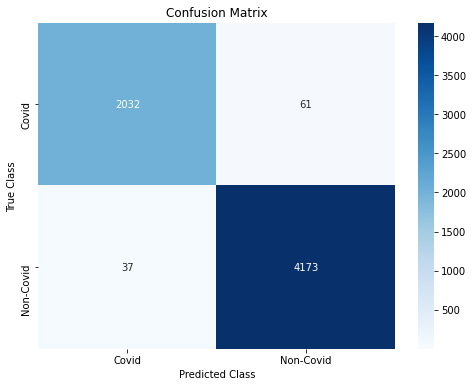

In [ ]:
#Print Confusion Matrix
import seaborn as sns
cm = confusion_matrix(rounded_labels,y_pred_bool)
labels = ['Covid', 'Non-Covid']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
#Print Confusion Matrix
import seaborn as sns
cm = confusion_matrix(rounded_labels,y_pred_bool)
labels = ['Covid', 'Non-Covid']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
from keras.applications.resnet import ResNet50 
from tensorflow.keras import models
from keras import models, regularizers, layers, optimizers, losses, metrics

In [ ]:
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(80,80,3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=(224,60,1))

In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 86, 86, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 40, 40, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 40, 40, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
type(resnet_model)

keras.engine.functional.Functional

In [ ]:
# MODEL
#model = models.Sequential()
#model.add(resnet_model)
#model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))

In [ ]:
print(model.summary())

NameError: ignored

In [ ]:
# Make the conv_base NOT trainable:

for layer in resnet_model.layers[:]:
   layer.trainable = False

print('resnet_model is now NOT trainable')

resnet_model is now NOT trainable


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],)

In [ ]:
history_vgg16=model.fit(X_train_mixed, y_train_mixed, batch_size=64, epochs=20, validation_split=0.2, verbose = 1)

Epoch 1/20
316/316 [==============================] - 43s 99ms/step - loss: 0.6744 - accuracy: 0.6440 - precision_5: 0.6010 - recall_5: 0.5178 - val_loss: 0.6408 - val_accuracy: 0.6690 - val_precision_5: 0.6613 - val_recall_5: 0.6465
Epoch 2/20
316/316 [==============================] - 26s 82ms/step - loss: 0.6418 - accuracy: 0.6637 - precision_5: 0.6618 - recall_5: 0.6506 - val_loss: 0.6362 - val_accuracy: 0.6690 - val_precision_5: 0.6626 - val_recall_5: 0.6557
Epoch 3/20
316/316 [==============================] - 26s 81ms/step - loss: 0.6421 - accuracy: 0.6604 - precision_5: 0.6623 - recall_5: 0.6563 - val_loss: 0.6350 - val_accuracy: 0.6690 - val_precision_5: 0.6631 - val_recall_5: 0.6585
Epoch 4/20
316/316 [==============================] - 26s 82ms/step - loss: 0.6387 - accuracy: 0.6647 - precision_5: 0.6632 - recall_5: 0.6591 - val_loss: 0.6379 - val_accuracy: 0.6690 - val_precision_5: 0.6633 - val_recall_5: 0.6599
Epoch 5/20
316/316 [==============================] - 26s 82ms/s

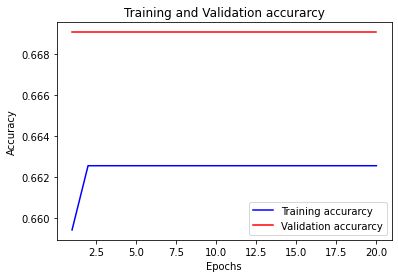

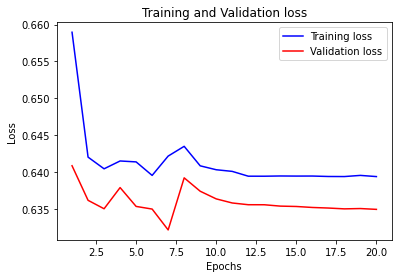

In [ ]:
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Results on test dataset
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
y_pred = model.predict(X_test_mixed, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test_mixed, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

132/132 [==============================] - 13s 58ms/step
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2732
           1       0.68      1.00      0.81      5677

    accuracy                           0.68      8409
   macro avg       0.34      0.50      0.40      8409
weighted avg       0.46      0.68      0.54      8409



In [ ]:
from tensorflow.keras.models import load_model

score,accuracy,precision,recall = model.evaluate(X_train_mixed,y_train_mixed,verbose=1)
f1 = (2*(precision*recall))/(precision+recall)
print("Train loss is {}".format(score))
print("Train accuracy is {}".format(accuracy))
print("Train Precision is {}".format(precision))
print("Train Recall is {}".format(recall))
print("Train f1_score is {}".format(f1))

789/789 [==============================] - 34s 43ms/step - loss: 0.6384 - accuracy: 0.6639 - precision_5: 0.6637 - recall_5: 0.6631
Train loss is 0.6384487748146057
Train accuracy is 0.6638522148132324
Train Precision is 0.6637341976165771
Train Recall is 0.6630869507789612
Train f1_score is 0.6634104163285381
